In [1]:
!pip install -q ultralytics split-folders easyocr pytesseract

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.2 MB/s eta 0:00:00a 0:00:01


In [22]:
import os
import cv2
import yaml
import random
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import splitfolders
import xml.etree.ElementTree as ET

from ultralytics import YOLO
import easyocr

import glob

In [10]:
# CHECK GPU

!nvidia-smi

Tue Feb 10 14:52:34 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.105.08             Driver Version: 580.105.08     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8             13W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [71]:
# SET PATHS (KAGGLE DATASET PATH)
# ==========================================================
DATASET_DIR = "/kaggle/input/car-plate-detection"
IMG_DIR = os.path.join(DATASET_DIR, "images")
ANN_DIR = os.path.join(DATASET_DIR, "annotations")

print("Images folder:", IMG_DIR)
print("Annotations folder:", ANN_DIR)

Images folder: /kaggle/input/car-plate-detection/images
Annotations folder: /kaggle/input/car-plate-detection/annotations


In [72]:
# FINAL OUTPUT FOLDER
# ==========================================================
FINAL_DIR = "/kaggle/working/CarDataset"

# remove old folder
if os.path.exists(FINAL_DIR):
    shutil.rmtree(FINAL_DIR)

os.makedirs(FINAL_DIR, exist_ok=True)

In [73]:
# CREATE TEMP DIR (splitfolders requires a folder)
# ==========================================================
TEMP_DIR = "/kaggle/working/temp_split"

if os.path.exists(TEMP_DIR):
    shutil.rmtree(TEMP_DIR)

os.makedirs(TEMP_DIR, exist_ok=True)

TEMP_IMAGES = os.path.join(TEMP_DIR, "images")
os.makedirs(TEMP_IMAGES, exist_ok=True)

In [74]:
# COPY IMAGES TO TEMP

image_files = glob.glob(os.path.join(IMG_DIR, "*.jpg")) + glob.glob(os.path.join(IMG_DIR, "*.png"))

for img_path in image_files:
    shutil.copy(img_path, TEMP_IMAGES)

print(f"✅ Copied {len(image_files)} images into temp_split/images")


✅ Copied 433 images into temp_split/images


In [75]:
# SPLIT DATASET USING SPLITFOLDERS

splitfolders.ratio(
    TEMP_IMAGES,
    output=FINAL_DIR,
    seed=42,
    ratio=(0.8, 0.1, 0.1)
)


Copying files: 433 files [00:00, 2186.32 files/s]


In [76]:
# Rename val -> valid
if os.path.exists(os.path.join(FINAL_DIR, "val")):
    os.rename(os.path.join(FINAL_DIR, "val"), os.path.join(FINAL_DIR, "valid"))

print("✅ Dataset split completed!")

✅ Dataset split completed!


In [77]:
# CREATE REQUIRED YOLO STRUCTURE

splits = ["train", "valid", "test"]

for split in splits:
    os.makedirs(os.path.join(FINAL_DIR, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(FINAL_DIR, split, "labels"), exist_ok=True)

print("✅ YOLO folders created!")

✅ YOLO folders created!


In [78]:
# XML -> YOLO FUNCTION
# ==========================================================
# ---> Extract width height of images using cv2

# CLASS_NAME = "licence"

# CLASS_ID = 0

# def convert_xml_to_yolo(xml_file, output_txt_file):

#     tree = ET.parse(xml_file)
#     root = tree.getroot()

#     img_width = int(root.find("size/width").text)
#     img_height = int(root.find("size/height").text)

#     yolo_lines = []

#     for obj in root.findall("object"):
#         label = obj.find("name").text

#         if label != CLASS_NAME:
#             continue

#         bbox = obj.find("bndbox")
#         xmin = int(float(bbox.find("xmin").text))
#         ymin = int(float(bbox.find("ymin").text))
#         xmax = int(float(bbox.find("xmax").text))
#         ymax = int(float(bbox.find("ymax").text))

#         x_center = ((xmin + xmax) / 2) / img_width
#         y_center = ((ymin + ymax) / 2) / img_height
#         w = (xmax - xmin) / img_width
#         h = (ymax - ymin) / img_height

#         yolo_lines.append(f"{CLASS_ID} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}")

#     with open(output_txt_file, "w") as f:
#         f.write("\n".join(yolo_lines))

In [ ]:
# --> Extract width height of images using .xml

# XML -> YOLO FUNCTION (USING CV2 IMAGE SHAPE)
# ==========================================================
# CLASS_NAME = "licence"   # correct label for this dataset
# CLASS_ID = 0

# def convert_xml_to_yolo(xml_file, image_file, output_txt_file):

#     img = cv2.imread(image_file)
#     if img is None:
#         print("❌ Error reading image:", image_file)
#         return

#     img_height, img_width = img.shape[:2]

#     tree = ET.parse(xml_file)
#     root = tree.getroot()

#     yolo_lines = []

#     for obj in root.findall("object"):
#         label = obj.find("name").text.strip()

#         if label != CLASS_NAME:
#             continue

#         bbox = obj.find("bndbox")
#         xmin = int(float(bbox.find("xmin").text))
#         ymin = int(float(bbox.find("ymin").text))
#         xmax = int(float(bbox.find("xmax").text))
#         ymax = int(float(bbox.find("ymax").text))

#         # YOLO Normalization
#         x_center = ((xmin + xmax) / 2) / img_width
#         y_center = ((ymin + ymax) / 2) / img_height
#         w = (xmax - xmin) / img_width
#         h = (ymax - ymin) / img_height

#         yolo_lines.append(f"{CLASS_ID} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}")

#     with open(output_txt_file, "w") as f:
#         f.write("\n".join(yolo_lines))

In [79]:
# MOVE IMAGES INTO images/ AND CREATE labels/ --> Extract width height of images using .xml

# for split in splits:

#     split_root = os.path.join(FINAL_DIR, split)

#     # splitfolders puts images directly inside train/valid/test folder
#     img_list = glob.glob(os.path.join(split_root, "*.jpg")) + glob.glob(os.path.join(split_root, "*.png"))

#     print(f"{split.upper()} images found:", len(img_list))

#     for img_path in img_list:

#         img_name = os.path.basename(img_path)
#         base_name = os.path.splitext(img_name)[0]

#         # move image into train/images
#         dst_img_path = os.path.join(FINAL_DIR, split, "images", img_name)
#         shutil.move(img_path, dst_img_path)

#         # xml annotation
#         xml_path = os.path.join(ANN_DIR, base_name + ".xml")

#         # output label file
#         label_path = os.path.join(FINAL_DIR, split, "labels", base_name + ".txt")

#         if os.path.exists(xml_path):
#             convert_xml_to_yolo(xml_path, label_path)
#         else:
#             open(label_path, "w").close()

# print("✅ Images moved + Labels created successfully!")

TRAIN images found: 346
VALID images found: 43
TEST images found: 44
✅ Images moved + Labels created successfully!


In [ ]:
# ==========================================================
# MOVE IMAGES INTO images/ AND CREATE labels/  ---> Extract width height of images using cv2
# ==========================================================
for split in splits:

    split_root = os.path.join(FINAL_DIR, split)

    # splitfolders puts images directly inside train/valid/test folder
    img_list = glob.glob(os.path.join(split_root, "*.jpg")) + glob.glob(os.path.join(split_root, "*.png"))

    print(f"{split.upper()} images found:", len(img_list))

    for img_path in img_list:

        img_name = os.path.basename(img_path)
        base_name = os.path.splitext(img_name)[0]

        # move image into split/images
        dst_img_path = os.path.join(FINAL_DIR, split, "images", img_name)
        shutil.move(img_path, dst_img_path)

        # xml annotation path
        xml_path = os.path.join(ANN_DIR, base_name + ".xml")

        # output txt label path
        label_path = os.path.join(FINAL_DIR, split, "labels", base_name + ".txt")

        if os.path.exists(xml_path):
            convert_xml_to_yolo(xml_path, dst_img_path, label_path)
        else:
            open(label_path, "w").close()

print("✅ Images moved + Labels created successfully!")

In [80]:
# CREATE data.yaml FILE

DATA_YAML_PATH = os.path.join(FINAL_DIR, "data.yaml")

data_yaml = {
    "train": os.path.join(FINAL_DIR, "train/images"),
    "val": os.path.join(FINAL_DIR, "valid/images"),
    "test": os.path.join(FINAL_DIR, "test/images"),
    "nc": 1,
    "names": ["licence"]
}

with open(DATA_YAML_PATH, "w") as f:
    yaml.dump(data_yaml, f)

print("✅ data.yaml created at:", DATA_YAML_PATH)

✅ data.yaml created at: /kaggle/working/CarDataset/data.yaml


In [81]:
# CHECK FILE COUNTS

for split in splits:
    img_count = len(glob.glob(os.path.join(FINAL_DIR, split, "images", "*.*")))
    lbl_count = len(glob.glob(os.path.join(FINAL_DIR, split, "labels", "*.txt")))

    print(f"{split.upper()} -> Images: {img_count} | Labels: {lbl_count}")

print("\n🎯 FINAL YOLO DATASET READY AT:", FINAL_DIR)

TRAIN -> Images: 346 | Labels: 346
VALID -> Images: 43 | Labels: 43
TEST -> Images: 44 | Labels: 44

🎯 FINAL YOLO DATASET READY AT: /kaggle/working/CarDataset


In [48]:
img = os.path.basename('/kaggle/input/car-plate-detection/images/Cars0.png')
img

'Cars0.png'

In [49]:
os.path.splitext(img)

('Cars0', '.png')

In [82]:
os.remove('/kaggle/working/CarDataset.zip')

In [70]:
shutil.rmtree('/kaggle/working/temp_split')

In [83]:
shutil.make_archive("/kaggle/working/CarDataset", "zip", "/kaggle/working/CarDataset")

print("✅ Zipped file created:", "/kaggle/working/CarDataset.zip")

✅ Zipped file created: /kaggle/working/CarDataset.zip


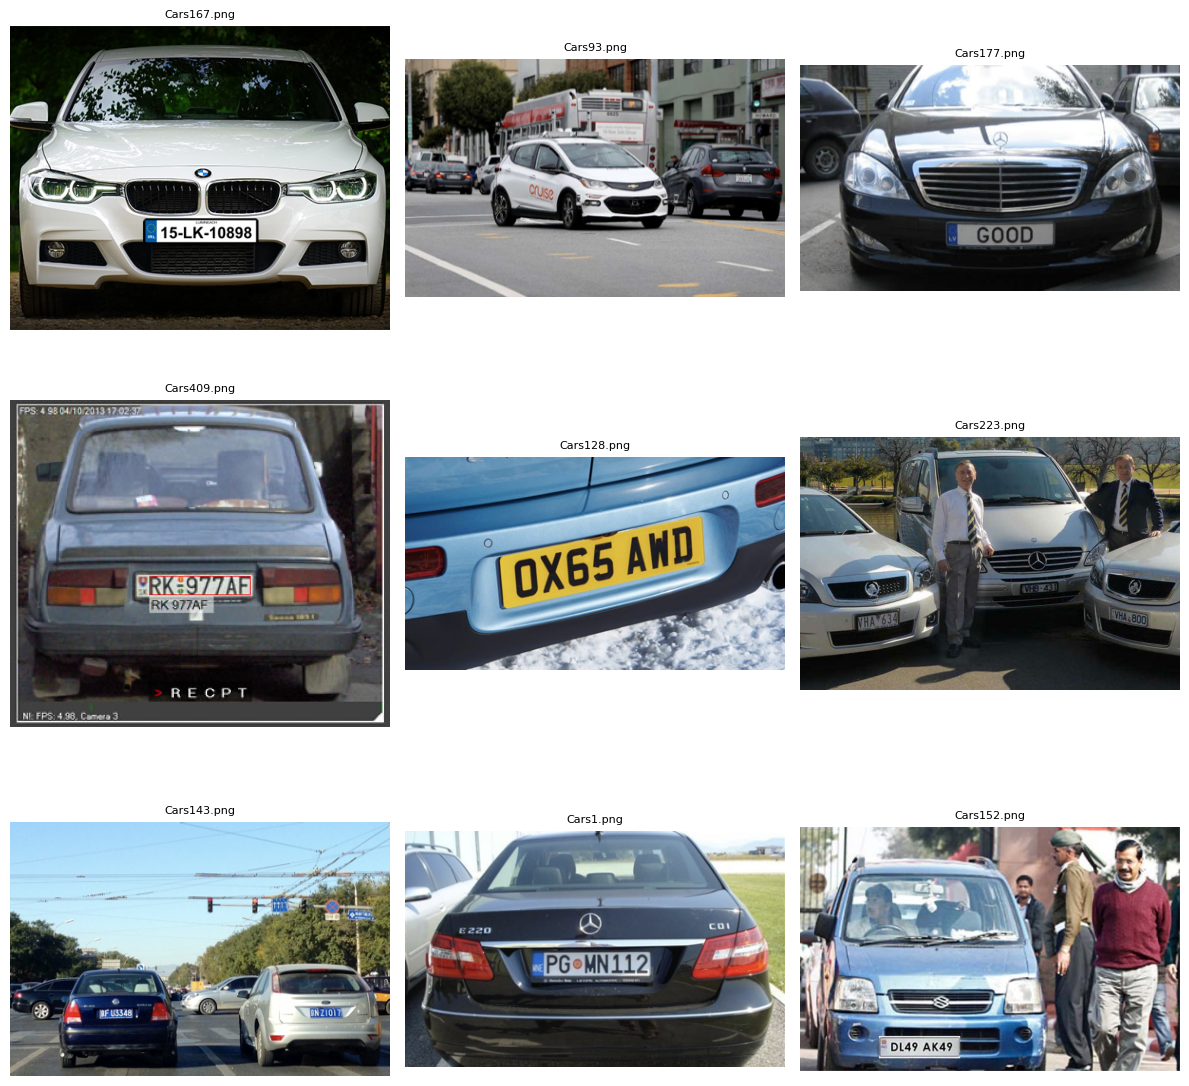

In [84]:
# VISUALIZE RANDOM TRAIN IMAGES

TRAIN_IMG_DIR = os.path.join(FINAL_DIR, "train/images")
train_images = os.listdir(TRAIN_IMG_DIR)
sample_images = random.sample(train_images, 9)

plt.figure(figsize=(12, 12))

for i, image_name in enumerate(sample_images):
    image_path = os.path.join(TRAIN_IMG_DIR, image_name)

    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(image_name, fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [85]:
# LOAD YOLO MODEL

model = YOLO("yolov8n.pt")

In [86]:
# TRAIN YOLO MODEL

model.train(
    data=DATA_YAML_PATH,
    epochs=30,
    batch=16,
    imgsz=640,
    name="car_plate_yolo",
    exist_ok=True
)


Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/CarDataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=car_plate_yolo, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d31a0606f90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [87]:
# READ results.csv
# ==========================================================
RESULTS_CSV = "/kaggle/working/runs/detect/car_plate_yolo/results.csv"
df = pd.read_csv(RESULTS_CSV)
df.head()

epoch      time  train/box_loss  train/cls_loss  train/dfl_loss  \
0      1   7.84648         1.50610         3.10355         1.35016   
1      2  12.20310         1.47513         2.02252         1.25837   
2      3  17.33990         1.48120         1.85677         1.29088   
3      4  22.47970         1.42825         1.71852         1.25232   
4      5  27.44090         1.51534         1.65215         1.30379   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0               0.00341            0.89796           0.09124   
1               0.00295            0.77551           0.03278   
2               0.27995            0.22449           0.17614   
3               0.24852            0.20408           0.10546   
4               0.48868            0.38776           0.31641   

   metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
0              0.03914       1.59047       3.79932       1.43912  0.000420   
1              0.01885       1.71154       4.01019       1.55960  0.000832   
2              0.08707       1.77287       3.62121       1.74723  0.001214   
3              0.02995       1.77438       3.73594       1.79165  0.001568   
4              0.13979       2.01566       3.07286       2.00504  0.001736   

     lr/pg1    lr/pg2  
0  0.000420  0.000420  
1  0.000832  0.000832  
2  0.001214  0.001214  
3  0.001568  0.001568  
4  0.001736  0.001736

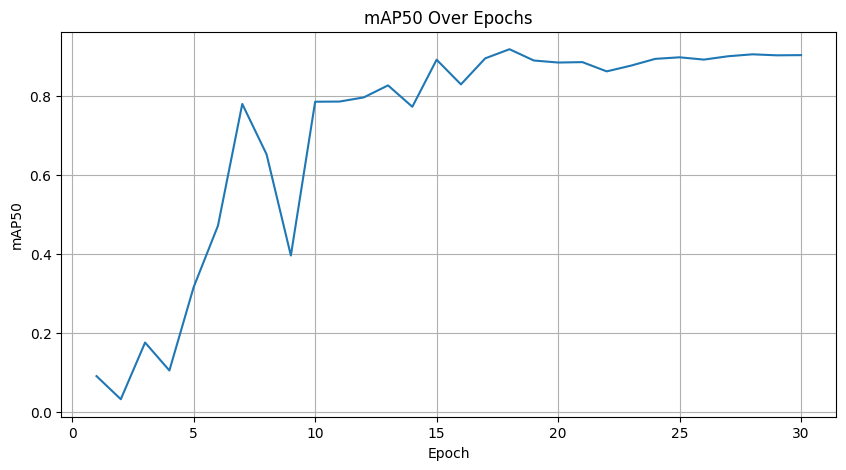

In [88]:
# ==========================================================
# PLOT mAP50 OVER EPOCHS
# ==========================================================
plt.figure(figsize=(10, 5))
plt.plot(df["epoch"], df["metrics/mAP50(B)"])
plt.title("mAP50 Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("mAP50")
plt.grid(True)
plt.show()

In [89]:
# ==========================================================
# LOAD BEST MODEL
# ==========================================================
BEST_MODEL_PATH = "/kaggle/working/runs/detect/car_plate_yolo/weights/best.pt"
best_model = YOLO(BEST_MODEL_PATH)

In [90]:
# ==========================================================
# EVALUATE ON TEST SET
# ==========================================================
best_model.val(
    data=DATA_YAML_PATH,
    split="test"
)

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 14913MiB)
Model summary (fused): 73 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2470.0±712.9 MB/s, size: 406.1 KB)
val: Scanning /kaggle/working/CarDataset/test/labels... 44 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 44/44 487.1it/s 0.1s
val: New cache created: /kaggle/working/CarDataset/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 2.3it/s 1.3s0.8s
                   all         44         48      0.868      0.826      0.907      0.492
Speed: 3.8ms preprocess, 9.2ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to /kaggle/working/runs/detect/val


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d31819207a0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
# ==========================================================
# CUSTOM FUNCTION TO DRAW YOLO BOXES
# ==========================================================
# def draw_boxes_custom(image_path, results, font_scale=1.0, thickness=2):

#     img = cv2.imread(image_path)

#     color = (
#         random.randint(0, 255),
#         random.randint(0, 255),
#         random.randint(0, 255)
#     )

#     for box in results.boxes:
#         x1, y1, x2, y2 = map(int, box.xyxy[0])
#         conf = float(box.conf[0])
#         cls = int(box.cls[0])

#         class_name = results.names[cls]
#         label = f"{class_name} {conf:.2f}"

#         cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness)

#         cv2.putText(
#             img,
#             label,
#             (x1, y1 - 10),
#             cv2.FONT_HERSHEY_SIMPLEX,
#             font_scale,
#             color,
#             thickness
#         )

#     return img

# VISUALIZE RANDOM TEST PREDICTIONS 
# ==========================================================
# TEST_IMG_DIR = os.path.join(FINAL_DIR, "test/images")
# test_images = os.listdir(TEST_IMG_DIR)
# sample_test_images = random.sample(test_images, 9)

# plt.figure(figsize=(12, 12))

# for i, img_name in enumerate(sample_test_images):
#     img_path = os.path.join(TEST_IMG_DIR, img_name)

#     results = best_model.predict(img_path, conf=0.4, imgsz=640, verbose=False)[0]

#     annotated_img = draw_boxes_custom(img_path, results, font_scale=1.0, thickness=2)
#     annotated_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)

#     plt.subplot(3, 3, i+1)
#     plt.imshow(annotated_img)
#     plt.title(img_name, fontsize=8)
#     plt.axis("off")

# plt.tight_layout()
# plt.show()

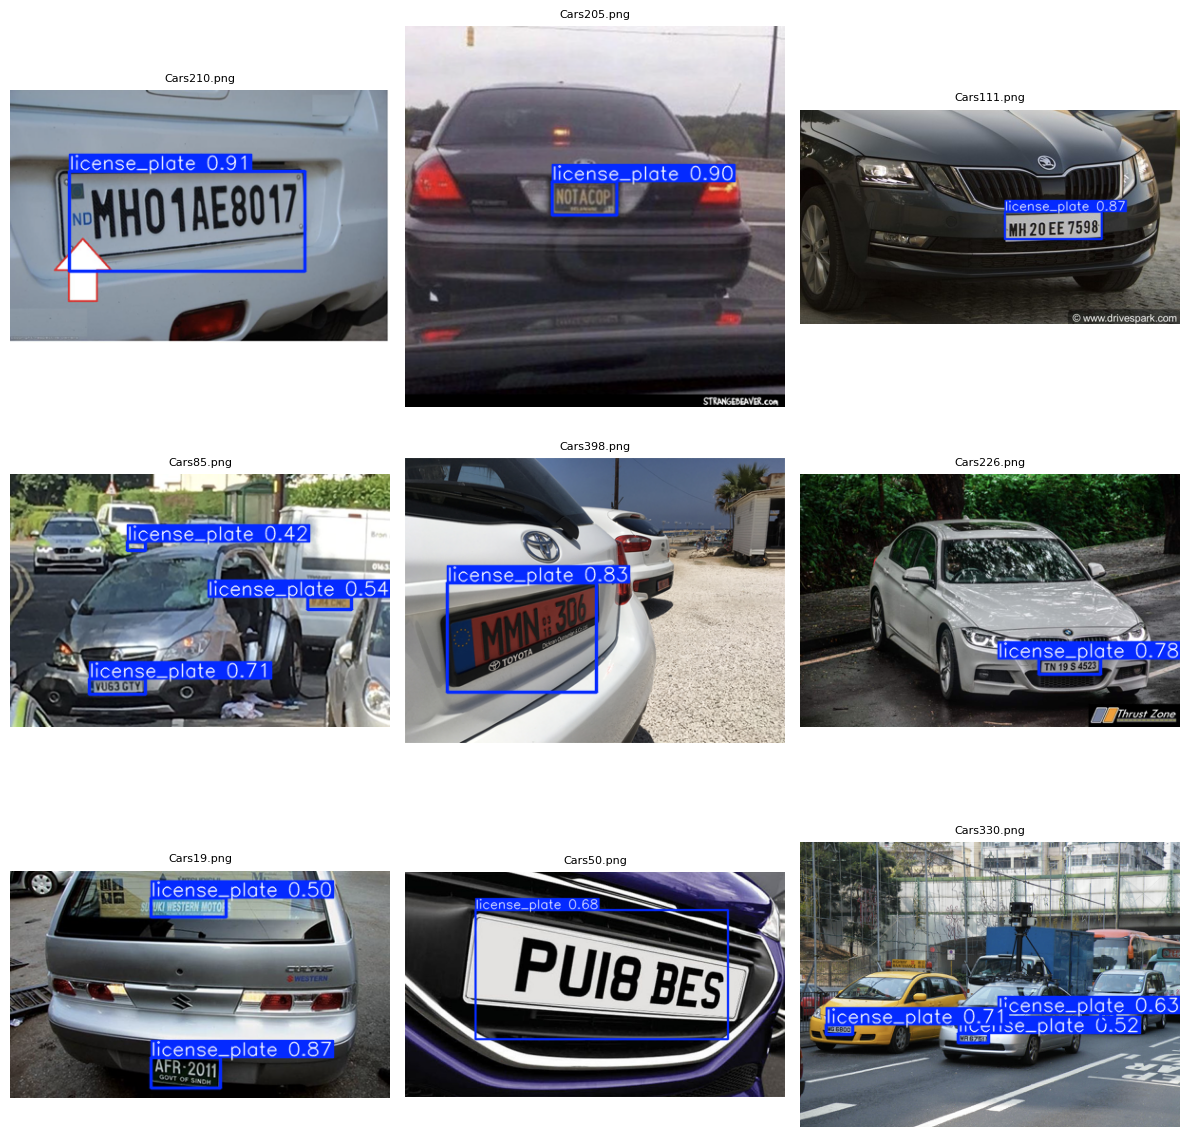

In [93]:
# ==========================================================
# VISUALIZE RANDOM TEST PREDICTIONS (USING results.plot())
# ==========================================================
TEST_IMG_DIR = os.path.join(FINAL_DIR, "test/images")

test_images = os.listdir(TEST_IMG_DIR)
sample_test_images = random.sample(test_images, 9)

plt.figure(figsize=(12, 12))

for i, img_name in enumerate(sample_test_images):
    img_path = os.path.join(TEST_IMG_DIR, img_name)

    # Predict
    results = best_model.predict(img_path, conf=0.4, imgsz=640, verbose=False)[0]

    # YOLO built-in plotting
    annotated_img = results.plot()

    # Convert BGR -> RGB
    annotated_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)

    # Plot
    plt.subplot(3, 3, i+1)
    plt.imshow(annotated_img)
    plt.title(img_name, fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [94]:
# OCR SETUP (EASYOCR)

reader = easyocr.Reader(["en"], gpu=True)

In [95]:
# ==========================================================
# FUNCTION: OCR ON DETECTED LICENSE PLATE REGION
# ==========================================================
def ocr_plate_from_detection(image_path, yolo_result, conf_thresh=0.4):

    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for box in yolo_result.boxes:
        conf = float(box.conf[0])

        if conf < conf_thresh:
            continue

        x1, y1, x2, y2 = map(int, box.xyxy[0])

        plate_crop = img_rgb[y1:y2, x1:x2]

        if plate_crop.shape[0] == 0 or plate_crop.shape[1] == 0:
            continue

        ocr_result = reader.readtext(plate_crop)

        plate_text = ""
        if len(ocr_result) > 0:
            plate_text = ocr_result[0][1]

        # Draw bounding box
        cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 255, 0), 3)

        # Draw OCR Text
        if plate_text != "":
            cv2.putText(
                img_rgb,
                f"{plate_text}",
                (x1, y1 - 15),
                cv2.FONT_HERSHEY_SIMPLEX,
                1.0,
                (255, 0, 0),
                3
            )

    return img_rgb



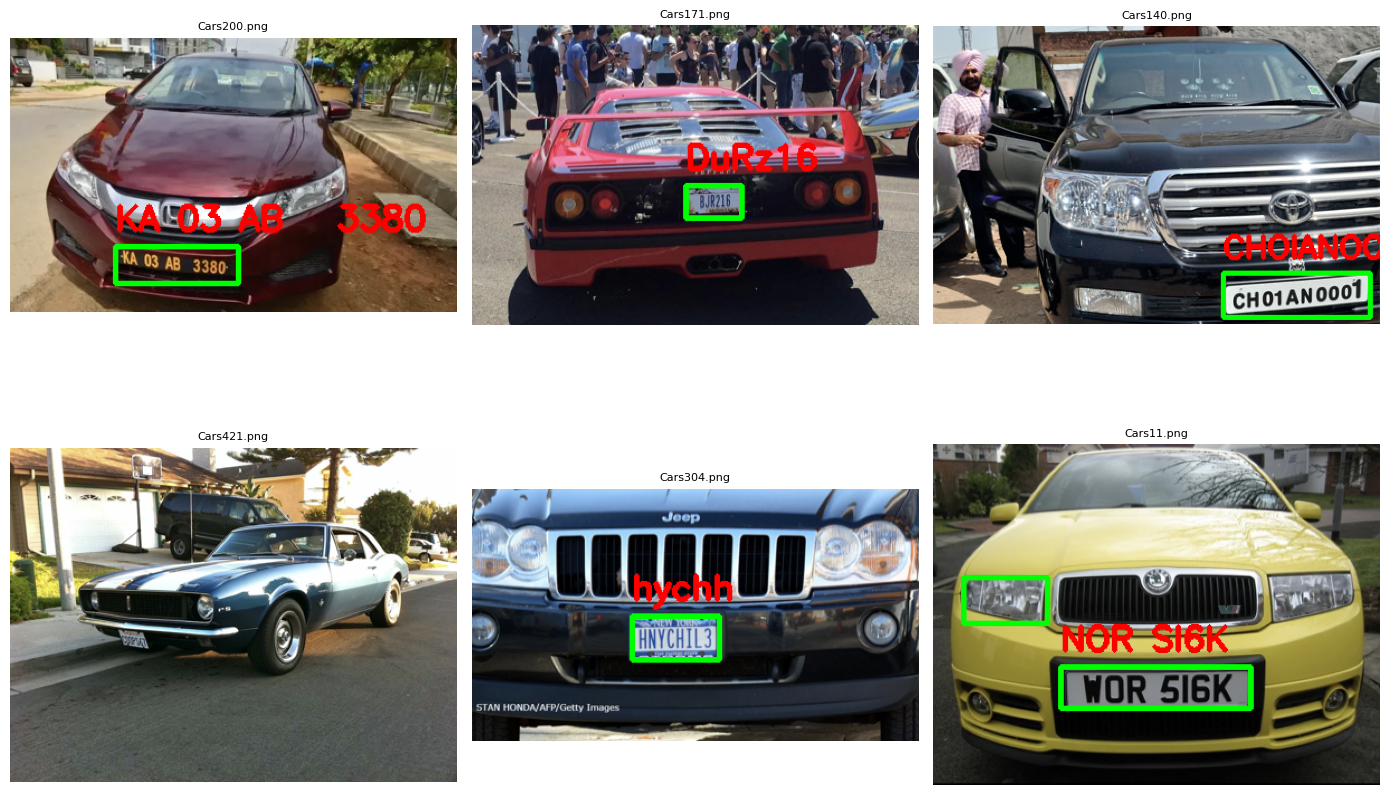

In [96]:
# ==========================================================
# VISUALIZE RANDOM TEST IMAGES WITH OCR TEXT
# ==========================================================
sample_test_images = random.sample(test_images, 6)

plt.figure(figsize=(14, 10))

for i, img_name in enumerate(sample_test_images):
    img_path = os.path.join(TEST_IMG_DIR, img_name)

    result = best_model.predict(img_path, conf=0.4, imgsz=640, verbose=False)[0]

    annotated_ocr_img = ocr_plate_from_detection(img_path, result, conf_thresh=0.4)

    plt.subplot(2, 3, i+1)
    plt.imshow(annotated_ocr_img)
    plt.title(img_name, fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [1]:
# python webcam.py

# import cv2
# from ultralytics import YOLO

# # Load your trained model
# model = YOLO("/kaggle/working/runs/detect/car_plate_yolo/weights/best.pt")   # or best.pt path

# # Open webcam (0 = default camera)
# cap = cv2.VideoCapture(0)

# if not cap.isOpened():
#     print("❌ Webcam not working!")
#     exit()

# print("✅ Webcam started. Press 'q' to quit.")

# while True:
#     ret, frame = cap.read()
#     if not ret:
#         break

#     # YOLO prediction
#     results = model.predict(frame, conf=0.4, imgsz=640, verbose=False)[0]

#     # YOLO built-in plot (draw bbox)
#     annotated_frame = results.plot()

#     # Show output
#     cv2.imshow("YOLO Car Plate Detection", annotated_frame)

#     # Press q to quit
#     if cv2.waitKey(1) & 0xFF == ord("q"):
#         break

# cap.release()
# cv2.destroyAllWindows()


❌ Webcam not working!
✅ Webcam started. Press 'q' to quit.


[ WARN:0@3.010] global cap_v4l.cpp:914 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@3.011] global obsensor_uvc_stream_channel.cpp:163 getStreamChannelGroup Camera index out of range


In [ ]:
# ==========================================================
# 🚗 WEBCAM LICENSE PLATE DETECTION + OCR (YOLOv8 + EasyOCR)
# ==========================================================
# Requirements:
# pip install ultralytics opencv-python easyocr
#
# Run:
# python webcam_ocr.py
#
# Press 'q' to quit
# ==========================================================


# import cv2
# import numpy as np
# from ultralytics import YOLO
# import easyocr


# # ==========================================================
# # LOAD YOLO MODEL
# # ==========================================================
# MODEL_PATH = "best_car_plate_model.pt"   # change if needed
# model = YOLO(MODEL_PATH)


# # ==========================================================
# # OCR SETUP
# # ==========================================================
# reader = easyocr.Reader(["en"], gpu=True)   # gpu=False if no GPU


# # ==========================================================
# # FUNCTION: CLEAN OCR TEXT
# # ==========================================================
# def clean_plate_text(text):
#     text = text.upper()
#     text = text.replace(" ", "")
#     text = text.replace("-", "")
#     return text


# # ==========================================================
# # FUNCTION: OCR FROM YOLO BOX
# # ==========================================================
# def ocr_from_plate_crop(plate_crop):
#     ocr_result = reader.readtext(plate_crop)

#     if len(ocr_result) == 0:
#         return ""

#     # take best confidence text
#     best_text = ""
#     best_conf = 0

#     for (bbox, text, conf) in ocr_result:
#         if conf > best_conf:
#             best_conf = conf
#             best_text = text

#     return clean_plate_text(best_text)


# # ==========================================================
# # START WEBCAM
# # ==========================================================
# cap = cv2.VideoCapture(0)

# if not cap.isOpened():
#     print("❌ ERROR: Webcam not detected!")
#     exit()

# print("✅ Webcam started successfully!")
# print("Press 'q' to quit.")


# # ==========================================================
# # MAIN LOOP
# # ==========================================================
# while True:
#     ret, frame = cap.read()
#     if not ret:
#         break

#     # Predict using YOLO
#     results = model.predict(frame, conf=0.4, imgsz=640, verbose=False)[0]

#     # Loop through detections
#     for box in results.boxes:
#         conf = float(box.conf[0])

#         if conf < 0.4:
#             continue

#         x1, y1, x2, y2 = map(int, box.xyxy[0])

#         # Crop plate region
#         plate_crop = frame[y1:y2, x1:x2]

#         if plate_crop.shape[0] == 0 or plate_crop.shape[1] == 0:
#             continue

#         # OCR
#         plate_text = ocr_from_plate_crop(plate_crop)

#         # Draw bounding box
#         cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 3)

#         # Draw label
#         label = f"Plate {conf:.2f}"
#         cv2.putText(frame, label, (x1, y1 - 40),
#                     cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

#         # Draw OCR text
#         if plate_text != "":
#             cv2.putText(frame, plate_text, (x1, y1 - 10),
#                         cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 0, 0), 3)

#     # Show webcam output
#     cv2.imshow("YOLO License Plate Detection + OCR", frame)

#     # Quit
#     if cv2.waitKey(1) & 0xFF == ord("q"):
#         break


# # ==========================================================
# # RELEASE
# # ==========================================================
# cap.release()
# cv2.destroyAllWindows()
# print("✅ Webcam closed.")


In [97]:
# ==========================================================
# SAVE ONE OUTPUT IMAGE WITH OCR
# ==========================================================
SAVE_OUTPUT_DIR = "/kaggle/working/output_predictions"
os.makedirs(SAVE_OUTPUT_DIR, exist_ok=True)

img_name = random.choice(test_images)
img_path = os.path.join(TEST_IMG_DIR, img_name)

result = best_model.predict(img_path, conf=0.4, imgsz=640, verbose=False)[0]
final_img = ocr_plate_from_detection(img_path, result)

save_path = os.path.join(SAVE_OUTPUT_DIR, "output_with_ocr.jpg")
cv2.imwrite(save_path, cv2.cvtColor(final_img, cv2.COLOR_RGB2BGR))

print("✅ Saved OCR prediction image at:", save_path)

✅ Saved OCR prediction image at: /kaggle/working/output_predictions/output_with_ocr.jpg


In [ ]:
# import shutil

# BEST_MODEL_PATH = "/kaggle/working/runs/detect/car_plate_yolo/weights/best.pt"
# SAVE_PATH = "/kaggle/working/best_car_plate_model.pt"

# shutil.copy(BEST_MODEL_PATH, SAVE_PATH)

# print("✅ Best model saved at:", SAVE_PATH)
